In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#simulate 60 days of defect data
np.random.seed(42)
days = pd.date_range(start='2024-01-18',periods=60)
sample_size=np.random.randint(80,120,size=60) #daily sample size
true_defect_rate=0.05

defect_count = np.random.binomial(sample_size, true_defect_rate)

In [2]:
df= pd.DataFrame({'Day': days,'Sample_Size':sample_size,'Defects':defect_count})

In [3]:
df.head()

,Day,Sample_Size,Defects
0,2024-01-18,118,5
1,2024-01-19,108,9
2,2024-01-20,94,6
3,2024-01-21,87,3
4,2024-01-22,100,5


In [4]:
df= pd.DataFrame({'Day':days,'Sample_Size':sample_size,'Defects':defect_count})
df.head()

,Day,Sample_Size,Defects
0,2024-01-18,118,5
1,2024-01-19,108,9
2,2024-01-20,94,6
3,2024-01-21,87,3
4,2024-01-22,100,5


In [5]:
p_bar = df['Defects'].sum()/df['Sample_Size'].sum()


plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [6]:
#flag out of cotrol
df['out_of_control'] = (df['Defects'] > df['Sample_Size'])

In [7]:
df['out_of_control'] = (df['Defects'] > df['Sample_Size'])
print(df[df['out_of_control']][['Day', 'Defects']])

Empty DataFrame
Columns: [Day, Defects]
Index: []


In [8]:
# hypothesis testing to understand most defect are above the 0.5 per thershold

# if lasrt day's defect rate is sigficantly highr then avreage
from statsmodels.stats.proportion import proportions_ztest

last = df.iloc[-1]
count = last['Defects']
nobs = last ['Sample_Size']

stat, pval = proportions_ztest(count, nobs, value=p_bar, alternative='larger')
print(f"Z-stat: {stat:.2f}, p_value: {pval:.4f}")

if pval < 0.05:
  print("statistically significant difference detected")
else:
  print("No statistically significant difference detected")




Z-stat: 0.78, p_value: 0.2181
No statistically significant difference detected


In [9]:
# simulate data after 35 days threahold will be 10%

df.loc[35:,'Defects'] = np.random.binomial(df.loc[35:,'Sample_Size'], 0.10)
df['Defect_Rate'] = df['Defects'] / df['Sample_Size']

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#recalculate P bar and UCL and LCL
p_bar = df['Defects'].sum()/df['Sample_Size'].sum()
df['p_bar'] = p_bar

#calculate UCL
df['UCL'] = p_bar + 3 * np.sqrt(p_bar * (1 - p_bar) / df['Sample_Size'])
df['UCL'] = df['UCL'].clip(upper=1) # UCL cannot exceed 1

#calculate LCL
df['LCL'] = p_bar - 3 * np.sqrt(p_bar * (1 - p_bar) / df['Sample_Size'])
df['LCL'] = df['LCL'].clip(lower = 0)

#flag out of control points(true / False)
df['out_of_control'] = (df['Defect_Rate'] > df['UCL']) | (df['Defect_Rate'] < df['LCL'])
out_points = df[df['out_of_control']]

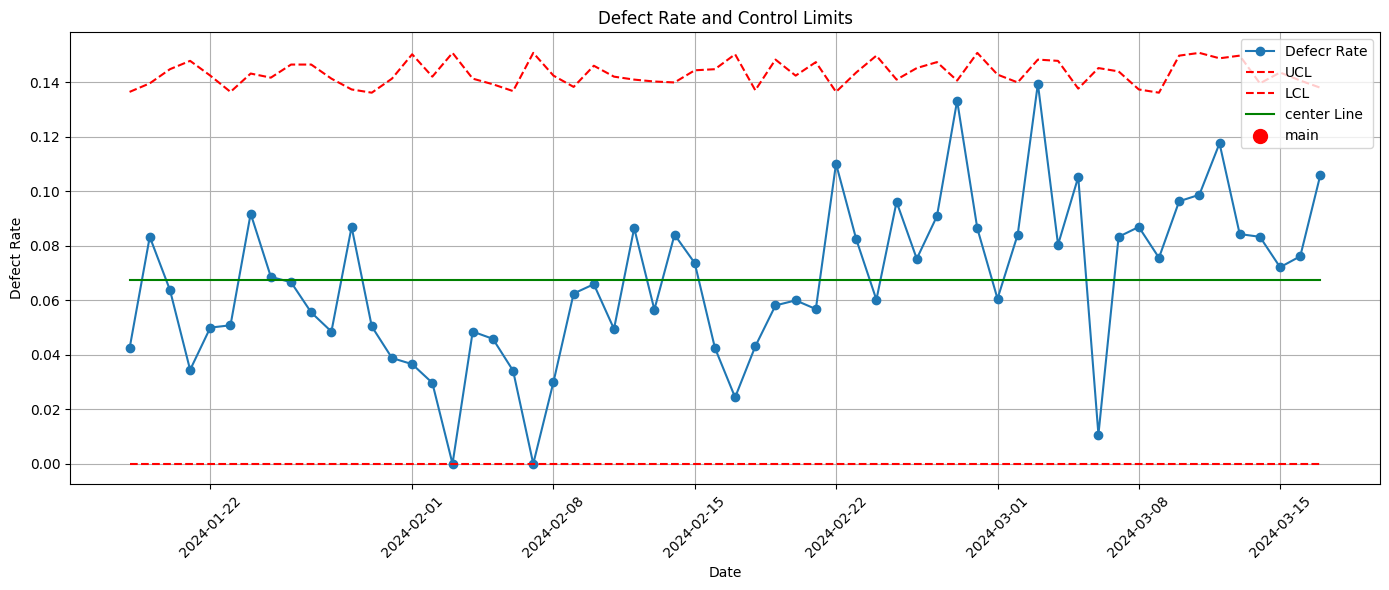

/tmp/ipython-input-11-2625133872.py:55: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


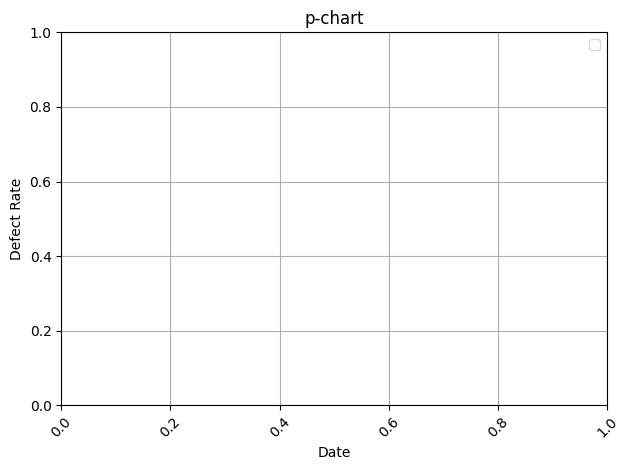

In [11]:
#plot
plt.figure(figsize=(14,6))
plt.plot(df['Day'],df['Defect_Rate'], marker ='o',label ='Defecr Rate')
plt.plot(df['Day'],df['UCL'], linestyle='--' ,color = 'red' , label = 'UCL')
plt.plot(df['Day'],df['LCL'], linestyle='--' ,color = 'red', label = 'LCL')
plt.plot(df['Day'],df['p_bar'], linestyle='-' ,color = 'green', label = 'center Line')
plt.scatter(out_points['Day'], out_points['Defect_Rate'], color = 'red', s=100 , zorder=5 , label = 'main')
# plt.scatter(out_points['Date'], out_points['Defect_Rate'], color = 'red', s=100 , zorder=5 , label = 'main')
# plt.axvline(df['Date'].iloc[first_shift_indeex] , color ='purple',linestyle = '--' , label = 'Shift')

first_shift_index = 35
first_out_after_shift = out_points[out_points.index >= first_shift_index].iloc[:1]

#ADD annotation to first out of control point after shift
if not first_out_after_shift.empty:
  x = first_out_after_shift['Day'].iloc[0]
  y = first_out_after_shift['Defect_Rate'].iloc[0]
  plt.annotate(
      'shift Detected',
      xy = (x, y),
      xytext = (x,y + 0.02),
      arrowprops=dict (facecolor = 'black',shrink = 0.05),
      fontsize = 10,
      ha = 'center')

# Lables and Layout
plt.title('Defect Rate and Control Limits')
plt.xlabel('Date')
plt.ylabel('Defect Rate')
plt.xticks(rotation = 45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#ADD annotation to first out of control point after shift
if not first_out_after_shift.empty:
  # Corrected column name from 'Date' to 'Day'
  x = first_out_after_shift['Day'].iloc[0]
  y = first_out_after_shift['Defect_Rate'].iloc[0]
  plt.annotate(
      'Shift Detected', # Added some text for the annotation
      xy = (x, y),
      xytext = (x,y + 0.02),
      arrowprops=dict (facecolor = 'black',shrink = 0.05),
      fontsize = 10,
      ha = 'center')

# Lables and Layout
plt.title('p-chart')
plt.xlabel('Date')
plt.ylabel('Defect Rate')
plt.xticks(rotation = 45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
# run rules
# step 1: Estimate standard deviation for each row
df['sigma'] = np.sqrt((df['p_bar'] * (1- df['p_bar'])) / df['Sample_Size'])

#step 2: compute 1sigma and 2 sigma boundaries
df['Upper_1sigma'] = df['p_bar'] + df['sigma']
df['Lower_1sigma'] = df['p_bar'] - df['sigma']
df['Upper_2sigma'] = df['p_bar'] + 2 * df['sigma']
df['Lower_2sigma'] = df['p_bar'] - 2 * df['sigma']

#Rule 1
df['Rule1'] = (df['Defect_Rate'] > df['UCL']) | (df['Defect_Rate'] < df['LCL'])

#Rule 2
rule2_flags = [False] * len(df)
for i in range (2, len(df)):
  upper = (df.loc[i-2:i,'Defect_Rate'] > df.loc[i-2: i, 'Upper_2sigma']).sum()
  lower = (df.loc[i-2:i,'Defect_Rate'] < df.loc[i-2: i, 'Lower_2sigma']).sum()
  rule2_flags[i] = (upper >=2) or (lower >= 2)
df['Rule2'] = rule2_flags

#Rule 3
df['Above_center'] = df['Defect_Rate'] > df['p_bar']
run_lengths = [1]
for i in range(1,len(df)):
  if df.loc[i, 'Above_center'] == df.loc[i-1, 'Above_center']:
    run_lengths.append(run_lengths[-1] + 1)
  else:
    run_lengths.append(1)
df['Run_Length'] = run_lengths
df['Rule4'] = df['Run_Length'] >= 8

# combine rules
df ['Any_Rule_violation'] = df[['Rule1'] | df['Rule2'] | df['Rule4']].any(axis = 1)

# view violations
violations =  df[df['Any_Rule_violation']]
print(violations[['Day' , 'Defects','Rule1','Rule2','Rule4']])

          Day  Defects  Rule1  Rule2  Rule4
0  2024-01-18        5  False  False  False
1  2024-01-19        9  False  False  False
2  2024-01-20        6  False  False  False
3  2024-01-21        3  False  False  False
4  2024-01-22        5  False  False  False
5  2024-01-23        6  False  False  False
6  2024-01-24        9  False  False  False
7  2024-01-25        7  False  False  False
8  2024-01-26        6  False  False  False
9  2024-01-27        5  False  False  False
10 2024-01-28        5  False  False  False
11 2024-01-29       10  False  False  False
12 2024-01-30        6  False  False  False
13 2024-01-31        4  False  False  False
14 2024-02-01        3  False  False  False
15 2024-02-02        3  False  False  False
16 2024-02-03        0  False  False  False
17 2024-02-04        5  False  False  False
18 2024-02-05        5  False  False  False
19 2024-02-06        4  False  False   True
20 2024-02-07        0  False  False   True
21 2024-02-08        3  False  F

/tmp/ipython-input-12-3724238196.py:34: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  df ['Any_Rule_violation'] = df[['Rule1'] | df['Rule2'] | df['Rule4']].any(axis = 1)
/tmp/ipython-input-12-3724238196.py:34: FutureWarning: 'any' with datetime64 dtypes is deprecated and will raise in a future version. Use (obj != pd.Timestamp(0)).any() instead.
  df ['Any_Rule_violation'] = df[['Rule1'] | df['Rule2'] | df['Rule4']].any(axis = 1)


In [13]:
# cp and Cpk most IMP

LSL = 0.02
USL = 0.08
mu = df['Defects'].mean()
sigma = df['Defects'].std()

cp = (USL - LSL)/(6 * sigma)
cpk = min ((USL - mu) / (3 * sigma) , (mu - LSL) / (3 * sigma))

print(f"cp = {cp:.2f} , cpk = {cpk:.2f}")


cp = 0.00 , cpk = -0.74


In [14]:
## bootstrapping
boot_means = [np.mean(np.random.choice(df['Defects'] , size = len(df) , replace=True)) for _ in range(1000)]
ci_lower = np.percentile(boot_means , 2.5)
ci_upper = np.percentile(boot_means , 97.5)

print(f"95% CI for average defect rate: ({ci_lower:.4f}, {ci_upper:.4f})")

95% CI for average defect rate: (5.9833, 7.4171)


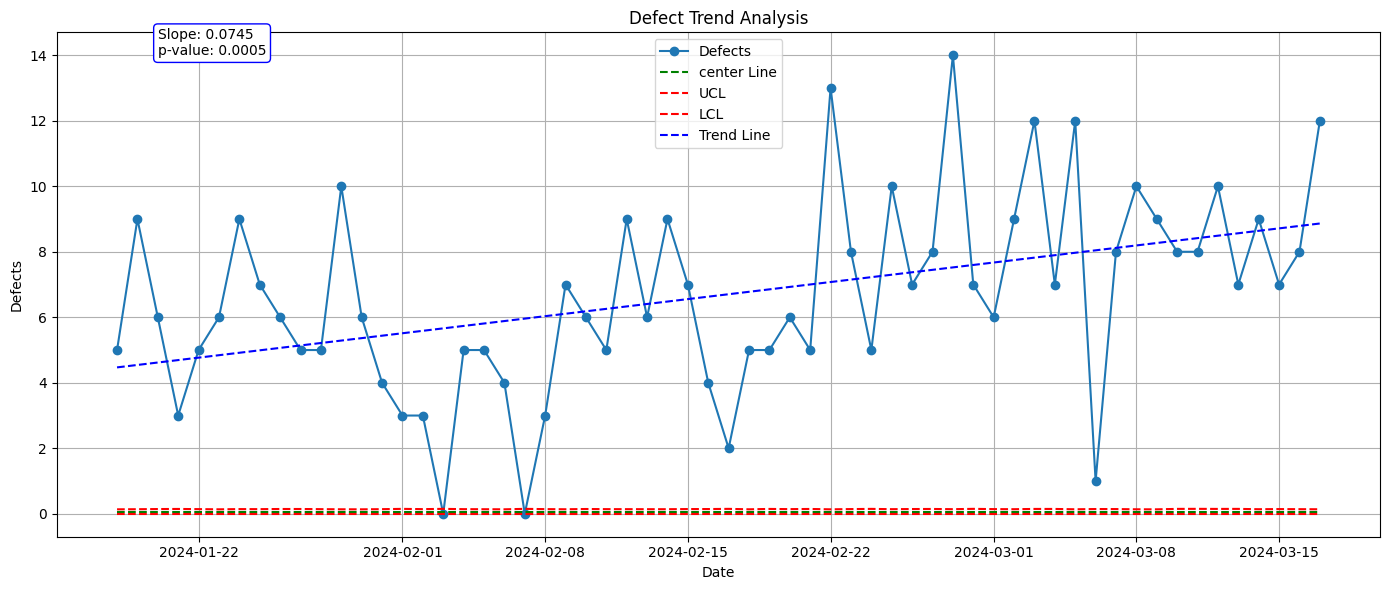

In [15]:
# apply regression Fit Line

#step 1  craete dayFrame
from scipy.stats import linregress
# Remove this line as 'Day' column already exists and has date values

#step 2 perform Linear Regression
# Convert 'Day' to numerical format for regression
df['Day_numeric'] = range(len(df))
trend_result = linregress(df['Day_numeric'], df['Defects'])

slope = trend_result.slope
p_value = trend_result.pvalue
intercept = trend_result.intercept

#Step 3 calculate Predicted Tread Line
df['Trend_Line'] = intercept + slope * df['Day_numeric']

#step 4 plot
plt.figure(figsize=(14,6))
# Corrected 'market' to 'marker'
plt.plot(df['Day'],df['Defects'],marker ='o',label = 'Defects')
plt.plot(df['Day'],df['p_bar'],linestyle = '--',color = 'green',label = 'center Line')
plt.plot(df['Day'],df['UCL'],linestyle = '--',color = 'red',label = 'UCL')
plt.plot(df['Day'],df['LCL'],linestyle = '--',color = 'red',label = 'LCL')

#Add Trend Line - Use the original 'Day' column for plotting the trend line against dates
plt.plot(df['Day'],df['Trend_Line'],linestyle = '--',color = 'blue',label = 'Trend Line')

#Step 5 annotate with slope and p-value
plt.text(df['Day'].iloc[2] , max(df['Defects']),
    f"Slope: {slope:.4f}\np-value: {p_value:.4f}",
    fontsize = 10, bbox = dict(facecolor = 'white', edgecolor = 'blue', boxstyle = 'round'))


plt.title('Defect Trend Analysis')
plt.xlabel('Date')
plt.ylabel('Defects')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [16]:
#create CUSUM Chart

#CUSUM Parameter
target = df['Defect_Rate'].mean()
k=0.005
h=0.05

#initialize lists
# Start with the initial CUSUM values at index 0, which are typically 0
cusum_pos=[0]
cusum_neg=[0]

#cal CUSUM
# Iterate from the second day (index 1) up to the last day
for i in range(1, len(df)):
  p_i = df.loc[i, 'Defect_Rate']

  # Calculate the positive CUSUM value for the current day
  s_pos = max(0, cusum_pos[-1] + (p_i - target - k))
  cusum_pos.append(s_pos)

  # Calculate the negative CUSUM value for the current day
  s_neg = min(0, cusum_neg[-1] + (p_i - target + k))
  cusum_neg.append(s_neg)

# Now that the loop has completed and the lists are populated, assign them to the DataFrame columns
df['CUSUM_Pos'] = cusum_pos
df['CUSUM_Neg'] = cusum_neg

# Display the first few rows of the DataFrame to confirm the new columns have been added
print(df.head())

         Day  Sample_Size  Defects  out_of_control  Defect_Rate     p_bar  \
0 2024-01-18          118        5           False     0.042373  0.067329   
1 2024-01-19          108        9           False     0.083333  0.067329   
2 2024-01-20           94        6           False     0.063830  0.067329   
3 2024-01-21           87        3           False     0.034483  0.067329   
4 2024-01-22          100        5           False     0.050000  0.067329   

        UCL  LCL     sigma  Upper_1sigma  ...  Rule1  Rule2  Above_center  \
0  0.136535  0.0  0.023069      0.090397  ...  False  False         False   
1  0.139668  0.0  0.024113      0.091442  ...  False  False          True   
2  0.144868  0.0  0.025846      0.093175  ...  False  False         False   
3  0.147927  0.0  0.026866      0.094195  ...  False  False         False   
4  0.142506  0.0  0.025059      0.092388  ...  False  False         False   

   Run_Length  Rule4  Any_Rule_violation  Day_numeric  Trend_Line  CUSUM_P

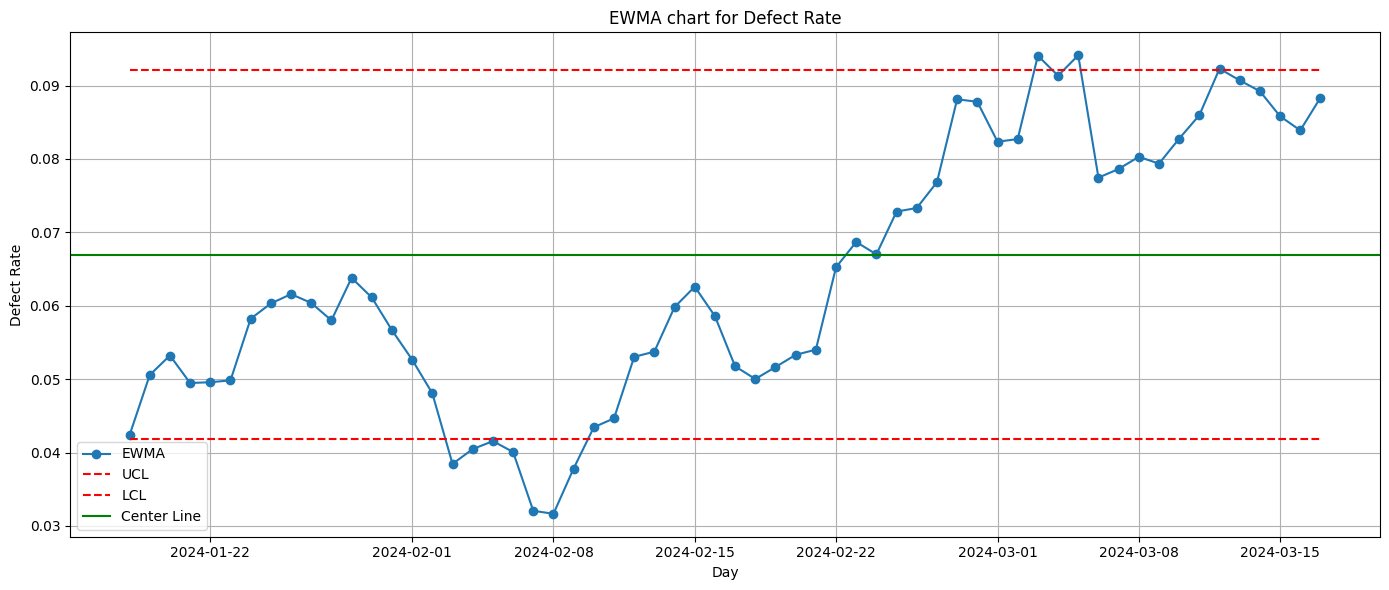

In [17]:
# EWMA model
# parameters
lambda_ = 0.2
L= 3

# Initialize EWMA
df['EWMA'] = 0.0
df.loc[0,'EWMA'] = df.loc[0,'Defect_Rate']

# Calculate EWMA
for i in range(1, len(df)):
  df.loc[i,'EWMA'] = lambda_ * df.loc[i,'Defect_Rate'] + (1-lambda_) * df.loc[i-1,'EWMA']

# estimate sigma
p_bar = df['Defect_Rate'].mean()
avg_n = df['Sample_Size'].mean()
sigma = np.sqrt((p_bar * (1-p_bar)) / avg_n)

# Calculate EWMA Control Limits
df['UCL_EWMA'] = p_bar + L * sigma * np.sqrt(lambda_ / (2 - lambda_))
df['LCL_EWMA'] = p_bar - L * sigma * np.sqrt(lambda_ / (2 - lambda_))

#plot EWMA
plt.figure(figsize=(14,6))
plt.plot(df['Day'], df['EWMA'], marker = 'o', label='EWMA')
plt.plot(df['Day'], df['UCL_EWMA'],linestyle='--', color = 'red', label='UCL')
plt.plot(df['Day'], df['LCL_EWMA'],linestyle='--', color = 'red', label='LCL')
plt.axhline(p_bar , color = 'green',linestyle='-', label = 'Center Line')
plt.title('EWMA chart for Defect Rate')
plt.xlabel('Day')
plt.ylabel('Defect Rate')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [18]:
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu # Import the function here

# Create a dummy DataFrame 'merged' for demonstration
# Replace this section with your actual data loading/creation
data = {
    'is_playoff': [False] * 50 + [True] * 50,
    'total_runs': np.random.randint(10, 30, size=100)
}
merged = pd.DataFrame(data)
# seprate scroes into two groups based on is_playoff flag
league_scores = merged[merged['is_playoff'] == False]['total_runs']
playoff_scores = merged[merged['is_playoff'] == True]['total_runs']

# Run the mann-Whitney U test (non-parametric test for median differences)
u_statistic, p_value = mannwhitneyu(league_scores, playoff_scores, alternative='two-sided')

#Display result
print(f"Mann-Whitney U-statistic: {u_statistic}")
print(f"p-value: {p_value}")

# Interpret the result
if p_value < 0.05:
  print("The diffrence in scrores between playoofs and league matches is statistically significant")
else:
  print("The diffrence in scrores between playoofs and league matches is not statistically significant")

Mann-Whitney U-statistic: 1077.5
p-value: 0.23490428812558273
The diffrence in scrores between playoofs and league matches is not statistically significant


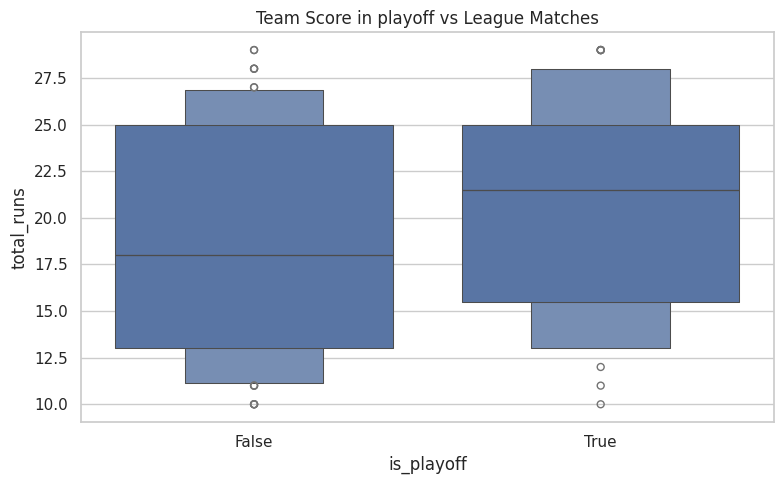

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

#set plot style
sns.set(style = 'whitegrid')

# 1. average Runs is olayoff vs League Matches
plt.figure(figsize = (8,5))
sns.boxenplot(data = merged , x = 'is_playoff' , y = 'total_runs')
plt.title("Team Score in playoff vs League Matches")
plt.xlabel('is_playoff')
plt.ylabel('total_runs')
plt.tight_layout()
plt.show()

In [20]:
# Home vs Away flags
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create a dummy DataFrame 'merged' for demonstration
# Replace this section with your actual data loading/creation
data = {
    'is_playoff': [False] * 50 + [True] * 50,
    'total_runs': np.random.randint(10, 30, size=100),
    # Add dummy data for the missing columns
    'batting_team': ['Team A'] * 50 + ['Team B'] * 50,
    'team1': ['Team A'] * 100,
    'team2': ['Team B'] * 100,
    # Add a dummy 'period' column
    'period': ['Period 1'] * 50 + ['Period 2'] * 50
}
merged = pd.DataFrame(data)

# The columns 'batting_team', 'team1', and 'team2' are now added to the dummy DataFrame 'merged'
merged['home_team'] = merged['batting_team'] == merged['team1']
merged['away_team'] = merged['batting_team'] == merged['team2']

## top scoring team per period

top_scoring_teams = (
    merged.groupby(['batting_team', 'period'])['total_runs']
    .mean()
    .reset_index()
    .sort_values(by = ['period','total_runs'], ascending = [True, False])
    )



In [21]:
#import the statistical test
from scipy.stats import mannwhitneyu

#1. Extract the two groups
home_scores = merged[merged['home_team'] == True]['total_runs']
away_scores = merged[merged['away_team'] == True]['total_runs']

#2. runs tha mann-whitnney U Test
u_statistic, p_value = mannwhitneyu(home_scores, away_scores, alternative='two-sided')

#3. print the results
print(f"Mann-Whitney U-statistic: {u_statistic}")
print(f"p-value: {p_value}")

#4. Interpret the result
if p_value < 0.05:
  print("The diffrence in scrores between home and away teams is statistically significant")
else:
  print("The diffrence in scrores between home and away teams is not statistically significant")

Mann-Whitney U-statistic: 1239.0
p-value: 0.9421770297063726
The diffrence in scrores between home and away teams is not statistically significant


In [22]:
print("check if any missing value exist")
print(merged.isna().any())

#percent of missing value per column
missing_percentages = merged.isna().mean() * 100
print(missing_percentages)

#show just the rows that have any missing data
print("show just the row that have any missing data")
missing_rows = merged[merged.isna().any(axis = 1)]
print(missing_rows)

check if any missing value exist
is_playoff      False
total_runs      False
batting_team    False
team1           False
team2           False
period          False
home_team       False
away_team       False
dtype: bool
is_playoff      0.0
total_runs      0.0
batting_team    0.0
team1           0.0
team2           0.0
period          0.0
home_team       0.0
away_team       0.0
dtype: float64
show just the row that have any missing data
Empty DataFrame
Columns: [is_playoff, total_runs, batting_team, team1, team2, period, home_team, away_team]
Index: []


In [26]:
#1. count matches per team
match_counts = (
    merged.groupby(['batting_team', 'period'])
    .size()
    .reset_index(name='match_count')
)

#2. pivot to get pre and post match counts in separate columns
match_counts_pivot = match_counts.pivot(index = 'batting_team', columns = 'period', values = 'match_count').fillna(0)

# try:
#     min_matches
# except NameError:
#     min_matches = 10

# Define min_matches before use
min_matches = 10


#3. filter team that meet minimum match criteria in both periods
qualified_teams = match_counts_pivot[
    (match_counts_pivot.get('Period 1', 0) >= min_matches) &
    (match_counts_pivot.get('Period 2', 0) >= min_matches)
].index.tolist()

#4. filter original merged dataset to includ only qualifide teams
filtered_merged = merged[merged['batting_team'].isin(qualified_teams)]

#Display filter team list and shape of filtered dataset
print("Qualified Teams:", qualified_teams)
print("filtered Dataset size:", filtered_merged.shape)

Qualified Teams: []
filtered Dataset size: (0, 8)


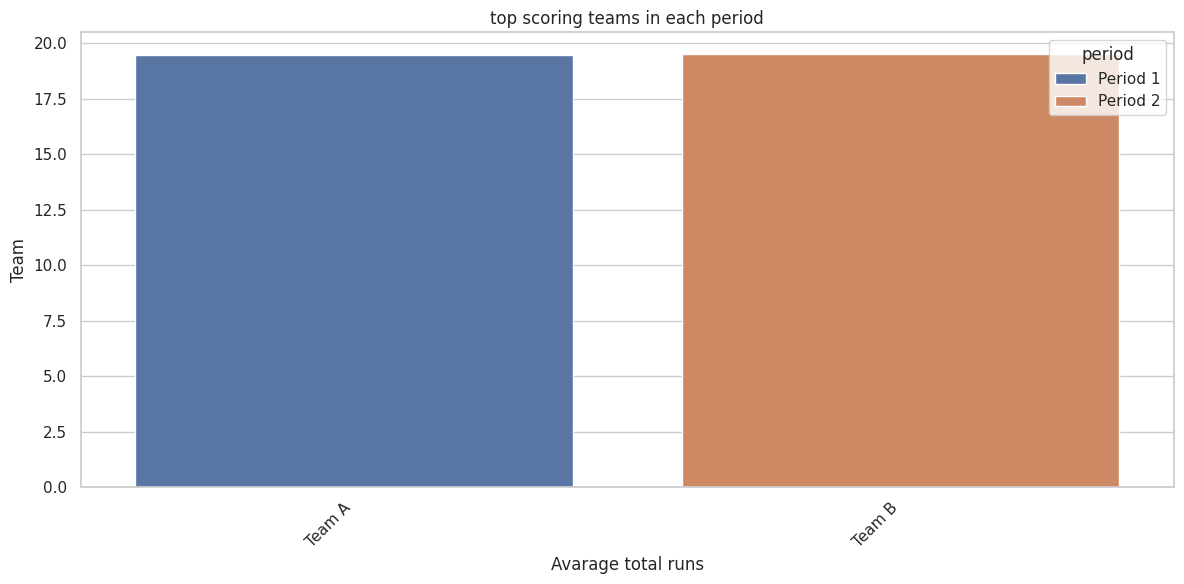

In [27]:
# plot bar chart
# Group by team and period to calculate avarage total runs per match

top_scoring_teams = (
merged.groupby(['batting_team', 'period'])['total_runs']
    .mean()
    .reset_index()
    .sort_values(by = ['period','total_runs'], ascending = [True, False])
    )

#plot the results using a barplot
plt.figure(figsize = (12,6))
sns.barplot(data = top_scoring_teams , x = 'batting_team' , y = 'total_runs' , hue = 'period')

#beauty the plot
plt.title('top scoring teams in each period')
plt.xlabel('Avarage total runs')
plt.ylabel('Team')
plt.xticks(rotation = 45, ha = 'right')
plt.tight_layout()
plt.show()
